### Import

In [818]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#plot
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

#technical analysis
import ta
import ta.momentum
import ta.volatility

#### Ignore warnings

In [819]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [820]:
df = pd.read_csv("./data/nasdaq/csv/INTC.csv", sep=',')

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.index = range(len(df))

df.tail()
df.set_index('Date', inplace=True)

all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_dates) 
df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']] = df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']].interpolate(method='linear')
df['Open'] = df['Close'].shift(1)
df['High'] = df[['High', 'Open', 'Close']].max(axis=1)
df['Low'] = df[['Low', 'Open', 'Close']].min(axis=1)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

### Add technical analysis indicators

#### RSI - Relative Strength Index

In [821]:
df['RSI7'] = ta.momentum.RSIIndicator(df['Close'], window=7).rsi()
df['RSI14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['RSI30'] = ta.momentum.RSIIndicator(df['Close'], window=30).rsi()
df['RSI50'] = ta.momentum.RSIIndicator(df['Close'], window=50).rsi()

# df['MEAN_RSI7_5'] = df['RSI7'].rolling(window=5).mean()
# df['MEAN_RSI14_5'] = df['RSI14'].rolling(window=5).mean()
# df['MEAN_RSI30_5'] = df['RSI30'].rolling(window=5).mean()
# df['MEAN_RSI50_5'] = df['RSI50'].rolling(window=5).mean()

# df['DRSI7'] = df['RSI7'].diff()
# df['DRSI14'] = df['RSI14'].diff()
# df['DRSI30'] = df['RSI30'].diff()

#### SMA - Simple Moving Average

In [822]:
# df['SMA5'] = ta.trend.SMAIndicator(df['Close'], window=5).sma_indicator()
df['SMA10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()
df['SMA14'] = ta.trend.SMAIndicator(df['Close'], window=14).sma_indicator()
df['SMA50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()

#### EMA - Exponential Moving Average

In [823]:
# df['EMA5'] = ta.trend.EMAIndicator(df['Close'], window=5).ema_indicator()
# df['EMA10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
df['EMA14'] = ta.trend.EMAIndicator(df['Close'], window=14).ema_indicator()
# df['EMA14'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

### ADX - Average Directional Movement

In [824]:
df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14).adx()

### Bollinger Bands

In [825]:
bb = ta.volatility.BollingerBands(close=df['Close'])
df['HB'] = bb.bollinger_hband()
df['LB'] = bb.bollinger_lband()
df['MB'] = bb.bollinger_mavg()
df['%B'] = (df['Close'] - df['LB']) / (df['HB'] - df['LB'])
df['BBBandWidth'] = (df['HB'] - df['LB']) / df['MB']

In [826]:
#consecutive days above sma20
df['AboveSMA20'] = (df['Close'] > df['MB']).astype(int)
df['DASMA'] = 0
consecutive_count = 0
r = np.zeros(len(df), dtype=int)
for i in range(1, len(df)):
    if df['AboveSMA20'].iloc[i]:
        consecutive_count += 1
    else:
        consecutive_count = 0
    r[i] = consecutive_count
df['DASMA'] = r
df.drop(['AboveSMA20'], axis=1, inplace=True)

In [827]:
#consecutive days above sma20
df['BelowSMA20'] = (df['Close'] < df['MB']).astype(int)
df['DBSMA'] = 0
consecutive_count = 0
r = np.zeros(len(df), dtype=int)
for i in range(1, len(df)):
    if df['BelowSMA20'].iloc[i]:
        consecutive_count += 1
    else:
        consecutive_count = 0
    r[i] = consecutive_count
df['DBSMA'] = r
df.drop(['BelowSMA20'], axis=1, inplace=True)

### MACD

In [828]:
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['MACD_signal'] = ta.trend.MACD(df['Close']).macd_signal()
df['MACD_hist'] = ta.trend.MACD(df['Close']).macd_diff()

### Stochastic Oscillator

In [ ]:
df['SO'] = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close']).stoch()

In [831]:
df['SO'].tail()

15606    15.352733
15607     7.053946
15608     5.331950
15609     7.479644
15610     9.793176
Name: SO, dtype: float64

### Visualize

In [832]:
start = 2000
# vdf = df
vdf = df[start:start+250]

fig = make_subplots(rows=8, cols=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.HB, name='Bollinger High Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.LB, name='Bollinger Low Band'), row=1, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.MB, name='Bollinger Middle Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA10, name='SMA10'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA14, name='SMA14'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA50, name='SMA50'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.EMA14, name='EMA14'), row=3, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf['%B'], name='%B'), row=4, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.BBBandWidth, name='BandWidth'), row=5, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI30, name='RSI30'), row=6, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI14, name='RSI14'), row=7, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.ADX, name='ADX'), row=8, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Volume, name='Volume'), row=8, col=1)

fig.update_layout(
    autosize=False,
    width=1500,
    height=1500,
    margin=dict(l=30,r=30,b=30,
                t=30,pad=3
                ),
    paper_bgcolor="White",
)

### Trend

In [833]:
def calc_trend(df, n=5, threshold=0.01):
	trend = []	
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_mean = df['Close'].iloc[i+1:i+n+1].mean()
		current_close = df['Close'].iloc[i]
		if future_mean > current_close * (1 + threshold):
			trend.append('Up')
		elif future_mean < current_close * (1 - threshold):
			trend.append('Down')
		else:
			trend.append('Neutral')
	df['Trend'] = trend
	return df

In [834]:
def calc_trend_sma_ema(df, n=10, threshold=0.01):
	trend = []
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_sma = df['SMA14'].iloc[i + n]
		current_sma = df['SMA14'].iloc[i]
		future_ema = df['EMA14'].iloc[i + n]
		current_ema = df['EMA14'].iloc[i]
		if future_sma > current_sma * (1 + threshold) and future_ema > current_ema * (1 + threshold):
			trend.append('Up')
		elif future_sma < current_sma * (1 - threshold) and future_ema < current_ema * (1 - threshold):
			trend.append('Down')
		else:
			trend.append('Neutral')
	df['Trend'] = trend
	return df
		

In [835]:
df = calc_trend_sma_ema(df, n=10, threshold=0.01)

#### Delete invalid data

In [836]:
df = df[100:-100]
df.index = range(len(df))

In [837]:
df[5000:5010]

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,...,%B,BBBandWidth,DASMA,DBSMA,MACD,MACD_signal,MACD_hist,SO,SO_signal,Trend
5000,1994-03-04,4.250000,4.250000,1.156704e+08,4.390625,4.351563,2.667245,68.935819,65.027019,60.143953,...,0.873340,0.091849,2,0,0.059051,0.058642,0.000408,87.500153,63.541781,Up
5001,1994-03-05,4.302083,4.351563,1.157088e+08,4.416667,4.385417,2.687995,72.030922,66.960868,61.186316,...,0.938247,0.085470,3,0,0.066254,0.060165,0.006090,90.769325,82.339826,Up
5002,1994-03-06,4.338542,4.385417,1.157472e+08,4.442708,4.419271,2.708746,74.943529,68.817741,62.208759,...,1.018292,0.077583,4,0,0.073844,0.062900,0.010943,93.571472,90.613650,Up
5003,1994-03-07,4.375000,4.419271,1.157856e+08,4.468750,4.453125,2.729496,77.657930,70.597350,63.211277,...,1.062378,0.077142,5,0,0.081649,0.066650,0.014999,96.000000,93.446932,Up
5004,1994-03-08,4.375000,4.453125,8.030240e+07,4.484375,4.421875,2.710341,69.544515,66.807129,61.649588,...,0.910512,0.080933,6,0,0.084341,0.070188,0.014153,84.615385,91.395619,Up
5005,1994-03-09,4.421875,4.421875,9.344960e+07,4.500000,4.476563,2.743865,74.898795,69.857049,63.291434,...,0.992815,0.085433,7,0,0.089851,0.074121,0.015730,94.444557,91.686647,Up
5006,1994-03-10,4.265625,4.476563,1.219152e+08,4.484375,4.382813,2.686401,55.414484,59.725666,58.825325,...,0.715088,0.082661,8,0,0.085666,0.076430,0.009236,72.222335,83.760759,Up
5007,1994-03-11,4.281250,4.382813,1.300896e+08,4.382813,4.289063,2.628938,42.512109,51.657472,54.823359,...,0.437495,0.079739,0,1,0.073932,0.075930,-0.001998,50.000113,72.222335,Up
5008,1994-03-12,4.270833,4.289063,1.030955e+08,4.369792,4.317709,2.646496,46.917948,53.714920,55.774388,...,0.508899,0.077999,1,0,0.066181,0.073980,-0.007799,56.790199,59.670882,Up
5009,1994-03-13,4.260417,4.317709,7.610133e+07,4.380208,4.346354,2.664054,51.274615,55.743362,56.716974,...,0.582529,0.077448,2,0,0.061640,0.071512,-0.009873,63.580285,56.790199,Up


#### Indicator Analysis

In [838]:
# sma_threshold = 5
# print(len(df[df['DASMA'] >= sma_threshold]))
# print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
# print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
# print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

In [839]:
# print(len(df[df['DBSMA'] >= sma_threshold]))
# print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
# print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
# print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

In [840]:
upper_rsi_threshold = 70
print(len(df[df['RSI14'] > upper_rsi_threshold]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Up')]))

1697
34
290
1373


In [841]:
lower_rsi_threshold = 30
print(len(df[df['RSI14'] < lower_rsi_threshold]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Up')]))

882
698
162
22


In [842]:
df[:10] 

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,...,%B,BBBandWidth,DASMA,DBSMA,MACD,MACD_signal,MACD_hist,SO,SO_signal,Trend
0,1980-06-25,0.339844,0.339844,15494400.0,0.348958,0.343750,0.209440,52.787075,49.717132,53.519276,...,0.390185,0.051445,0,13,-0.000947,0.000158,-0.001105,33.331108,15.276756,Neutral
1,1980-06-26,0.343750,0.343750,10156800.0,0.348958,0.343750,0.209440,52.787075,49.717132,53.519276,...,0.403832,0.050952,0,14,-0.000818,-0.000037,-0.000780,33.331108,24.303932,Up
2,1980-06-27,0.343750,0.343750,6912000.0,0.350260,0.345052,0.210233,59.251210,52.411608,54.453434,...,0.486306,0.050490,0,15,-0.000604,-0.000151,-0.000453,41.663933,36.108716,Up
3,1980-06-28,0.344184,0.345052,6387200.0,0.349392,0.344184,0.209704,53.548843,50.469916,53.708999,...,0.445015,0.050315,0,16,-0.000498,-0.000220,-0.000278,36.108716,37.034586,Up
4,1980-06-29,0.343316,0.344184,5862400.0,0.348524,0.343316,0.209176,48.143286,48.533584,52.960015,...,0.403955,0.050429,0,17,-0.000479,-0.000272,-0.000207,30.553500,36.108716,Up
5,1980-06-30,0.342448,0.343316,5337600.0,0.347656,0.342448,0.208647,43.070808,46.607872,52.206874,...,0.372326,0.048831,0,18,-0.000528,-0.000323,-0.000205,27.270703,31.310973,Up
6,1980-07-01,0.342448,0.342448,9811200.0,0.352865,0.347656,0.211820,67.235653,57.503216,56.083309,...,0.730516,0.042656,1,0,-0.000144,-0.000287,0.000143,63.631918,40.485374,Up
7,1980-07-02,0.347656,0.347656,6585600.0,0.355469,0.350260,0.213406,73.738221,61.710424,57.851533,...,0.893445,0.043728,2,0,0.000365,-0.000157,0.000522,69.226638,53.376420,Up
8,1980-07-03,0.350260,0.350260,4550400.0,0.358073,0.352865,0.214994,78.677304,65.400738,59.537532,...,1.009820,0.047446,3,0,0.000968,0.000068,0.000900,73.334747,68.731101,Up
9,1980-07-04,0.352865,0.352865,8299200.0,0.360677,0.356120,0.216977,83.265324,69.372782,61.526811,...,1.094457,0.054778,4,0,0.001689,0.000392,0.001297,78.125151,73.562179,Up


In [843]:
df[-5:]

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,...,%B,BBBandWidth,DASMA,DBSMA,MACD,MACD_signal,MACD_hist,SO,SO_signal,Trend
15406,2022-08-30,32.150002,32.939999,40182500.0,33.070000,32.259998,32.259998,21.647934,28.454949,34.599931,...,0.026203,0.150276,0,12,-1.013638,-0.844652,-0.168987,2.631502,2.862212,Down
15407,2022-08-31,31.770000,32.259998,44074500.0,32.389999,31.920000,31.920000,19.307449,26.922302,33.741196,...,0.038383,0.164873,0,13,-1.085430,-0.892807,-0.192622,3.289464,3.123056,Down
15408,2022-09-01,31.129999,31.920000,36440700.0,31.920000,31.760000,31.760000,18.225614,26.206936,33.338391,...,0.071141,0.174686,0,14,-1.142070,-0.942660,-0.199410,12.426053,6.115673,Down
15409,2022-09-02,31.059999,31.760000,34893300.0,32.380001,31.219999,31.219999,14.931359,23.898847,32.004433,...,0.047083,0.185506,0,15,-1.216509,-0.997430,-0.219079,3.443325,6.386281,Down
15410,2022-09-03,30.877500,31.219999,37917375.0,32.132501,31.005000,31.005000,13.774842,23.029200,31.485543,...,0.068857,0.193103,0,16,-1.278117,-1.053567,-0.224550,2.829666,6.233015,Down


#### Rolling Normalize

In [844]:
def rolling_normalize(df, columns, window=100):
    result = df.copy()
    for col in columns:
        result[f'{col}'] = 0.0  # Khởi tạo cột normalized
    
    for i in range(len(df)):
        start = max(0, i - window + 1)

        window_data = df[columns].iloc[start:i+1]
        if len(window_data) < 2:
            continue

        window_values = window_data.values.flatten()
        min_val = window_values.min()
        max_val = window_values.max()
        if max_val == min_val:
            continue  # Tránh chia cho 0

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(window_data)
        # Gán giá trị normalized cho điểm cuối của cửa sổ
        for j, col in enumerate(columns):
            result.loc[df.index[i], f'{col}'] = scaled_data[-1, j]
    
    return result

In [845]:
print(df['Trend'].value_counts())


Trend
Up         5836
Neutral    4988
Down       4587
Name: count, dtype: int64


In [846]:
df.drop(['Open'], axis=1, inplace=True)
df.drop(['High'], axis=1, inplace=True)
df.drop(['Low'], axis=1, inplace=True)
df.drop(['Close'], axis=1, inplace=True)
# df.drop(['Volume'], axis=1, inplace=True)
df.drop(['Adjusted Close'], axis=1, inplace=True)
df.drop(['HB'], axis=1, inplace=True)
df.drop(['LB'], axis=1, inplace=True)
df.drop(['MB'], axis=1, inplace=True)
df.drop(['EMA14'], axis=1, inplace=True)
df.drop(['SMA10'], axis=1, inplace=True)
df.drop(['SMA14'], axis=1, inplace=True)
df.drop(['SMA50'], axis=1, inplace=True)

### Train Model

In [847]:
test_size = 0.15
# valid_size = 0.15
test_split_idx  = int(df.shape[0] * (1-test_size))
# valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))
# print(test_split_idx)
# print(valid_split_idx)
train_df  = df.loc[:test_split_idx].copy()
# valid_df  = df.loc[valid_split_idx:test_split_idx].copy()
test_df   = df.loc[test_split_idx:].copy()

In [848]:
y_train = train_df['Trend'].copy()
X_train = train_df.drop(['Trend'], axis=1)

# y_valid = valid_df['Trend'].copy()
# X_valid = valid_df.drop(['Trend'], axis=1)

y_test  = test_df['Trend'].copy()
X_test  = test_df.drop(['Trend'], axis=1)

X_train = X_train.drop(['Date'], axis=1)
# X_valid = X_valid.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13100 entries, 0 to 13099
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Volume       13100 non-null  float64
 1   RSI7         13100 non-null  float64
 2   RSI14        13100 non-null  float64
 3   RSI30        13100 non-null  float64
 4   RSI50        13100 non-null  float64
 5   ADX          13100 non-null  float64
 6   %B           13100 non-null  float64
 7   BBBandWidth  13100 non-null  float64
 8   DASMA        13100 non-null  int64  
 9   DBSMA        13100 non-null  int64  
 10  MACD         13100 non-null  float64
 11  MACD_signal  13100 non-null  float64
 12  MACD_hist    13100 non-null  float64
 13  SO           13100 non-null  float64
 14  SO_signal    13100 non-null  float64
dtypes: float64(13), int64(2)
memory usage: 1.5 MB


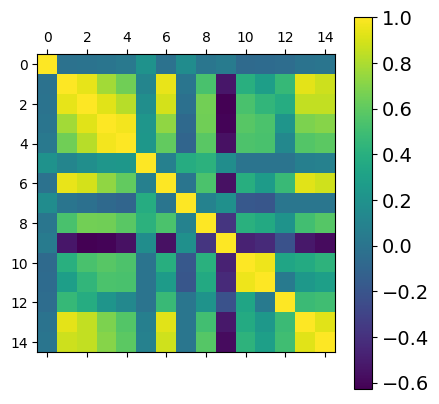

In [849]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')
plt.matshow(corr)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [850]:
le = LabelEncoder()
le.fit(['Up', 'Down', 'Neutral'])
y_train = le.transform(y_train)
# y_valid = le.transform(y_valid)
y_test = le.transform(y_test)
le.transform(['Up', 'Down', 'Neutral'])

array([2, 0, 1])

In [851]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [852]:
rus = RandomUnderSampler(random_state=42)
X_test, y_test = rus.fit_resample(X_test, y_test)

(array([5028., 5028., 5028.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

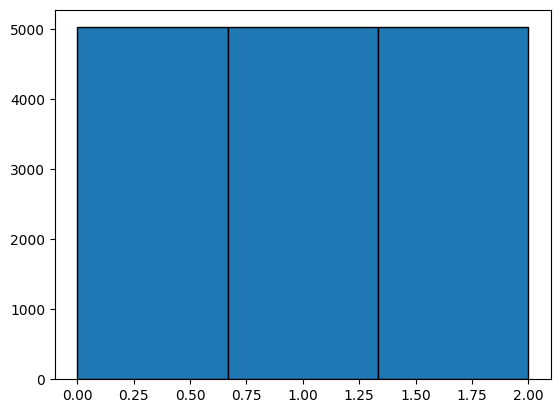

In [853]:
plt.hist(y_train, bins=3, edgecolor='black')

(array([617., 617., 617.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

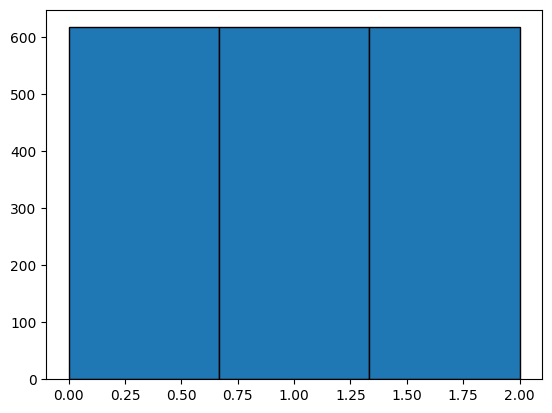

In [854]:
plt.hist(y_test, bins=3, edgecolor='black')

In [855]:
%%time

param_grid = {
    'max_depth': [8],
    'learning_rate': [0.1],
    'n_estimators': [300, 350, 400],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')

# Thiết lập GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Tối ưu hóa dựa trên accuracy
    n_jobs=3, 
    verbose=1
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# In tham số tốt nhất và điểm số
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


KeyboardInterrupt: 

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.5278

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.61       617
           1       0.39      0.39      0.39       617
           2       0.57      0.59      0.58       617

    accuracy                           0.53      1851
   macro avg       0.53      0.53      0.53      1851
weighted avg       0.53      0.53      0.53      1851


Confusion Matrix:
[[374 171  72]
 [172 241 204]
 [ 56 199 362]]


In [ ]:
le.transform(['Up', 'Down', 'Neutral'])

array([2, 0, 1])

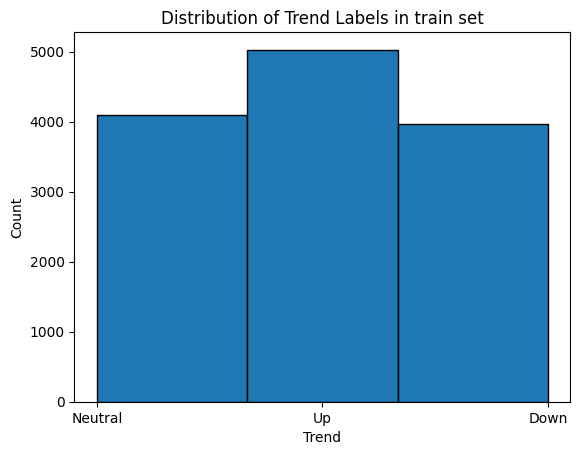

In [ ]:
plt.hist(train_df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels in train set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

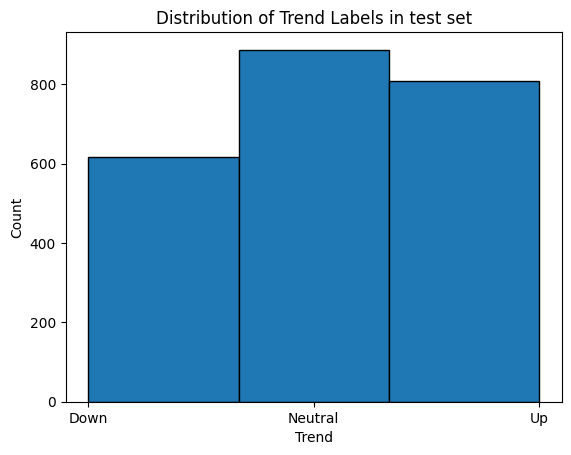

In [ ]:
plt.hist(test_df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels in test set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

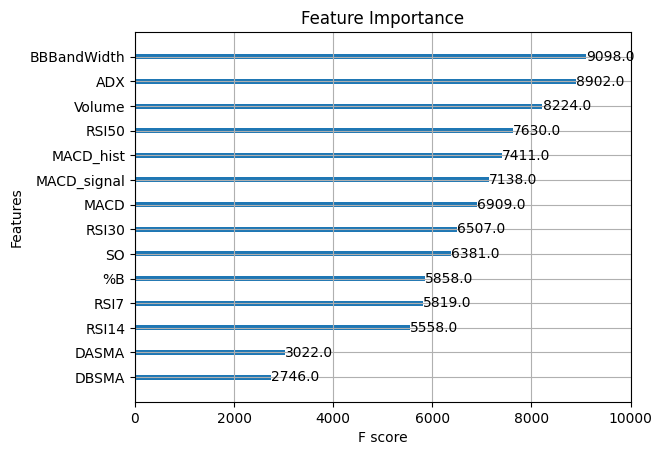

In [ ]:
xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.show()